# Midpoint Source Protocol for Quantum Links

This notebook is a demonstration of the Midpoint Source Protocol for Quantum Links. We shall take a step away from the QuREBB framework and use some bespoke code for the evaluation of the protocol. 

This tutotial will guide you through the basics of components that go into the protocol and how they are used for the evaluation of a midpoint source protocol. The tutoril is structured as follows:
- Brief Intro to Midpoint Source Protocol
- Components of the Protocol
- Understanding the Construction of a Entanglement Generation Source.
- Building a Heralded Entanglement Generation Source
- Quantum Memories: Sneak Peek
- Building and Simulating a Midpoint Source Protocol from the Components

In [1]:
# %load_ext autoreload
# %autoreload 2
import sys
import numpy as np
from dependencies_midpoint import *
import matplotlib.pyplot as plt

## Brief Intro to Midpoint Source Protocol

The midpoint source protocol is one of the canonical methods to generate entanglement between two distant parties. You have all delved into the details of the 'midpoint swap' or 'swap in the middle' protocol in the previous tutorials. The protocol was first suggested by Jones et. al in [Design and analysis of communication protocols for quantum repeater networks.]( https://doi.org/10.1088/1367-2630/18/8/083015). It relies on access to three main components:
1. A pair of quantum memories at the two distant parties that are wishing to generate entanglement. Let us call them Alice (A) and Bob (B).
2. A source of entangled photons at the 'midpoint' that a third party Charlie (C) is handling.
3. Quantum channels (i.e. mechanisms to send qubits) from C to A and B, as well classcial communication channels between all parties.

The overall protocol is quite simple. It proceeds as follows:
1. C generates a pair of entangled photons and sends one to A and the other to B. They *also notify* A and B that they have done so.
2. A and B receives the photons and store them in their quantum memories. If they have done so **successfully**, they communicate their success to each other.
3. Once both A and B have signalled success, they are sure that their memories are entangled. They can now use these entangled memories to do any task that they need entanglement for (e.g. teleporting a quantum state, generating a shared secret key between them, etc.)
4. If either A or B have signalled failure, they abort the protocol and try again.

The flow of the protocol is shown in the figure below. One might note that this is quite straightforward and does not require any fancy quantum operations. However, the devil is in the details. We shall see the various requirement for the protocol to work in the next section.

![SPDC](./Images/MPS_Protocol_Diag.png)
**Figure**: Overview of the midpoint source protocol.


## Components of the Protocol

As stated above the protocol requires three main components. Let us look at each of them in turn. 

### Quantum Memories
Most generally put quantum memories are physical systems that are capable of storing quantum information for a long time. In the context of the protocol, we require quantum memories that not only can can store quantum information for a long time but are also also be able to interact with photons. The latter requirement is necessary for the memories to be able to store entangled photons coming from the midpoint source at C. Furthermore, we require that the end parties A and B **know** when their share of the entangled photon pair is successfully stored in their memories. This is necessary for the protocol to work, as they need to communicate with each other to know when to proceed to the next step or whether to abort the protocol and restart.

We generally refer to this set of requirements for a quantum memory as a 'heralded photonic quantum memory'. Examples of this memory have been proposed in the literature for as long as quantum information has been alive - and quite recently, experiments have been able to demonstrate them as well. We defer a detailed discussion of what these memories actually do to a later section. Curious readers can look at the following references for more details:

- Vacancy center defects in diamond
  - Chen, K. C., Bersin, E., & Englund, D. (2021). ***A polarization encoded photon-to-spin interface***. [Npj Quantum Information, 7(1), 1–6](https://doi.org/10.1038/s41534-020-00337-3). 
  - Nguyen, C. T. et. al (2019). ***Quantum Network Nodes Based on Diamond Qubits with an Efficient Nanophotonic Interface***. [Physical Review Letters, 123(18), 183602](https://doi.org/10.1103/PhysRevLett.123.183602). 
  - Vasconcelos, R. et. al ***Scalable spin–photon entanglement by time-to-polarization conversion***. [Npj Quantum Information, 6(1), 1–5](https://doi.org/10.1038/s41534-019-0236-x). 
- Vacancies in other host materials
  - SiC: Parthasarathy, S. K., Kallinger, B., Kaiser, F., Berwian, P., Dasari, D. B. R., Friedrich, J., & Nagy, R. (2023). ***Scalable Quantum Memory Nodes Using Nuclear Spins in Silicon Carbide.*** [Physical Review Applied, 19(3), 034026.](https://doi.org/10.1103/PhysRevApplied.19.034026)
  - Si: Higginbottom, D. B., Asadi, F. K., Chartrand, C., Ji, J.-W., Bergeron, L., Thewalt, M. L. W., Simon, C., & Simmons, S. (2023). ***Memory and Transduction Prospects for Silicon T Center Devices.*** [PRX Quantum, 4(2), 020308.](https://doi.org/10.1103/PRXQuantum.4.020308)
- Atomic Ensemble Memories
  - Fleischhauer, M., & Lukin, M. D. (2002). ***Quantum memory for photons: Dark-state polaritons.*** [Physical Review. A, 65(2), 022314.](https://doi.org/10.1103/PhysRevA.65.022314)
  - Namazi, M., Kupchak, C., Jordaan, B., Shahrokhshahi, R., & Figueroa, E. (2017). ***Ultralow-Noise Room-Temperature Quantum Memory for Polarization Qubits.*** [Physical Review Applied, 8(3), 034023.](https://doi.org/10.1103/PhysRevApplied.8.034023)
  - Shinbrough, K., Pearson, D. R., Jr, Fang, B., Goldschmidt, E. A., & Lorenz, V. O. (2023). ***Broadband Quantum Memory in Atomic Ensembles.*** [In arXiv [quant-ph]. arXiv.](http://arxiv.org/abs/2301.08772)

### Entanglement Generation Source
The entanglement generation source is a device that is capable of generating entangled photons. This is the most important component of the protocol. Although generating entanglement might be trivial for some quantum systems, we specifically care about the generation of entangled photons. This is because photons are the most convenient carriers of quantum information over long distances, either via transmission on optical fibers (such as those that form the backbone of the Internet) or by free-space optical links (which is how satellites communicate with earth bound transmitter and each other). This task however is highly non-trivial and has been studied extensively. 

The type of entanglement is dependent on how the qubit is defined. For example, if we define the qubit in terms of the 'presence' or 'absence' of a photon such as 
$$\ket{\bar{0}}= \ket{0}; \quad \ket{\bar{1}}= \ket{1} $$
then the entanglement generation source is a device that generates entangled photons in the form of
\begin{equation}
\begin{split}  
\ket{\Psi^+} = \frac{1}{\sqrt{2}}\left(\ket{0}\ket{0} + \ket{1}\ket{1}\right) \\
\ket{\Psi^-} = \frac{1}{\sqrt{2}}\left(\ket{0}\ket{0} - \ket{1}\ket{1}\right) \\
\ket{\Phi^+} = \frac{1}{\sqrt{2}}\left(\ket{0}\ket{1} + \ket{1}\ket{0}\right) \\ 
\ket{\Phi^-} = \frac{1}{\sqrt{2}}\left(\ket{0}\ket{1} - \ket{1}\ket{0}\right)
\end{split}
\end{equation}
where $\ket{0}$ and $\ket{1}$ are the states of the photon in the 'presence' and 'absence' basis respectively. 

In contrast if we define the qubit in terms of the polarization of the photon, then the qubits are defined as
$$\ket{\bar{0}}=\ket{0,1}\equiv\ket{H}; \quad \ket{\bar{1}}=\ket{1,0}\equiv\ket{V} $$
Then the entanglement generation source is a device that generates entangled photons in the form of
\begin{equation}
\begin{split}
\ket{\Psi^+} = \frac{1}{\sqrt{2}}\left(\ket{H}\ket{H} + \ket{V}\ket{V}\right) \\
\ket{\Psi^-} = \frac{1}{\sqrt{2}}\left(\ket{H}\ket{H} - \ket{V}\ket{V}\right) \\
\ket{\Phi^+} = \frac{1}{\sqrt{2}}\left(\ket{H}\ket{V} + \ket{V}\ket{H}\right) \\
\ket{\Phi^-} = \frac{1}{\sqrt{2}}\left(\ket{H}\ket{V} - \ket{V}\ket{H}\right)
\end{split}
\end{equation}
where $\ket{H}$ and $\ket{V}$ are the states of the photon in the horizontal and vertical polarization basis respectively. This forms part of the more general 'dual-rail' encoding of the qubit in a photon, where the qubit is encoded in the presence of a photon in ***one of two different modes***. 

Dual rail encodings are the most common way to encode qubits in photons - they can refer modes which are disticnt in time of arrival, frequency, polarization, spatial characteristics etc. For the rest of this tutorial, we shall assume that the entangled qubits are encoded in the dual-rail encoding of the photon. We shall do a deep dive into the construction of such a source in the next section. 

### Quantum and Classical Channels for Information Transfer

The final component of the protocol is the quantum and classical channels that are used to transfer information between the parties. The quantum channels are used in the process for C to send the qubits to A and B, i.e. to send the entangled photons from the midpoint source to the quantum memories of the end parties. The classical channels are used by all parties to communicate information either about the arrival of a photon (from C to A and B) and also about the success or failure of the entanglement generation process between the parties (from A and B to each other).

Quantum channels that we shall consider here form a specific subset of the general concept of quantum channels that you may have seen in the previous tutorials. Our quantum channel is one that is capable of sending a single photonic qubit from one party to another. These are generally refered to as 'bosonic pure loss channels' in the literature. We shall see how to work with such a channel in the next section.

The classical channels that we shall consider simply a classical bit channel that can send a string of bits from one party to another. In most quantum communication protocols, this is assumed to be a perfect channel, i.e. the bits are sent without any errors. We shall also assume this for our protocol considerations. 

## Understanding the Construction of a Entanglement Generation Source
Photonic entanglement generation sources rely on nonlinear interactions of a pump photon in a specific type of material, generally referred to as a nonlinear crystal. The pump photon is generally a high energy photon (i.e. a photon with a high frequency) that is converted into two lower energy photons (i.e. photons with lower frequencies). The process is generally referred to as 'spontaneous parametric downconversion' (SPDC). We usuially refer to the pump photon as the 'pump' and the two lower energy photons as the 'signal' and 'idler' photons. The process is shown in the figure below.

![SPDC](./Images/MPS_SPDC_Process.png)
**Figure**: Diagram of the SPDC process with the necessary physical constraints visualized.


The generated photons satisfy the energy conservation law, i.e. the sum of the frequencies of the generated photons is equal to the frequency of the pump photon. In addition, the net momentum of the generated photons is equal to the momentum of the pump photon. This is generally referred to as 'phase matching' and is a key requirement for the generation of entangled photons. We may succinctly write this as
$$\omega_p = \omega_s + \omega_i; \quad \vec{k}_p = \vec{k}_s + \vec{k}_i$$
where $\omega_p$ is the frequency of the pump photon, $\omega_s$ and $\omega_i$ are the frequencies of the signal and idler photons respectively, and $\vec{k}_p$, $\vec{k}_s$ and $\vec{k}_i$ are the wavevectors of the pump, signal and idler photons respectively. The nonlinear process relies on differeing indices of refraction for the pump, signal and idler photons. The net range of frequencies that can be generated by the SPDC process is limited by the bandwidth of the nonlinear crystal, and is generally referred to as the **phase-matching bandwidth**. Alternate processes such as 'spontaneous four-wave mixing' (SFWM) can also be used to generate entangled photons; for this tutorial we shall focus on SPDC.

To go from a single SPDC process, to a source of entangled polarization encoded photonic qubits, we must introduce some mechanism to erase path information of the photons. The general SPDC based polarization entaglement source consists of wo separate nonlinear crystals. By placing the crystals close to one another, we 'erase' information about which crystal the photon was generated in. Thus if the photon pair generated in the first crystal is in the state $ \ket{H}\ket{V} $, then the photon pair generated in the second crystal is in the state $\ket{V}\ket{H}$. The relative polarization of the pump, signal and idler photons depend on the type of SPDC process that is used. For now let us only consider the simple case where we seek to generate entanglement of the form $\ket{\Psi^+} = (\ket{H,V}+\ket{V,H})/\sqrt{2} $. 

![SPDC](./Images/MPS_SPDC_Sources.png)
**Figure**: Visualizations of typical SPDC based polarization entanglement sources - (a) based on subsequent down-conversions, (b) based on a Sagnac loop interferometer, (c) based on repeated down-conversion interactions. The three sources shown in (a)-(c) can be visulaized to be a single 'black box' source in (d) generating the specified state. (Image adapted from <a href="https://doi.org/10.1103/PhysRevA.60.R773"> (a) Kwiat et. al 1999</a>, <a href="https://journals.aps.org/pra/abstract/10.1103/PhysRevA.73.012316">(b) Kim et. al 2006 </a>, <a href="https://doi.org/10.1103/PhysRevA.61.042304">(c) Kok and Braunstein et. al 2000</a>, <a href="https://doi.org/10.1103/PhysRevApplied.17.034071">(d) Dhara et. al 2022</a>)


The general output state of the SPDC process is given (in the Fock basis) as
\begin{equation}
\ket{\Psi^\pm} = \sum_{n=0}^{\infty} \sum_{k}^{n} \sqrt{\frac{p(n)}{n+1}}\ket{n-k,k,k,n-k}
\end{equation}
where $p(n)=(n+1) N_s^n/(N_s+1)^{n+2}$ with the modes being ordered as : Horizontal 1, Vertical 1, Horizontal 2, Vertical 2. The first pair of modes (Horizontal and Vertical 1 ) are cosnidered to be sent to Alice and the second pair of modes (Horizontal and Vertical 2) are considered to be sent to Bob. $N_s$ istypically called the mean-photon number per mode in the source - we shall work in the regime where $N_s\lesssim 0.2$ to ensure that only terms upto $p(2)$ constibute to the state.

Expanding the state out in the Fock basis for upto $n=2$, we get
\begin{equation}
\ket{\Psi^\pm} = N_0 \left[ \sqrt{p(0)} \ket{0,0,0,0} + \sqrt{\frac{p(1)}{2}} (\ket{1,0,0,1} + \ket{0,1,1,0}) + \sqrt{\frac{p(2)}{3}} (\ket{2,0,0,2} + \ket{0,2,2,0} + \ket{1,1,1,1}) \right]
\end{equation}
where $N_0$ is a normalization constant. In this equation, $p(0)$ represents the probability of generating a vacuum state in all four modes -indicating that the pump photons is not downverted. Correspondingly $p(1)$ represents the probability of generating a single pair of photons in one of the modes and vacuum in the rest, and $p(2)$ represents the probability of generating two photons pairs in the modes and vacuum in the rest. The terms corrsponding to $p(1)$ are the useful terms as they signify the generation of entangled photons in the polarization basis. On the other hand, the terms corresponding to $p(2)$ are the 'noise' terms as the terms are not in the polarization qubit basis defined earlier.

Since $p(n)$ is a geometric series we always have $p(0)>p(1)>p(2)>...$. This always means that the proportion of 'vacuum' (no downconverted photons) will exceed both the single photon and two photon terms. This is a key limitation of SPDC based entanglement generation sources. The ratio of the single photon term to the vacuum term is typically referred to as the 'brightness' of the source. 

Furthermore, the terms corresponding to $p(2)$ contribute to noise. If the communication system was perfect and photons weren't lost then the user could tell apart between the cases where they received a single photon and two photons. However, in the presence of loss, this is not so simple. The two-pair terms after losing a photon cannot be discriminated from the single pair terms. This is a key limitation of SPDC based entanglement generation sources. We usually will optimize $N_s$ to maximize the brightness of the source while keeping the noise low. This can be evaluated by looking at the fidelity of the generated state with the ideal state $\ket{\Psi^+}$.

We note the following features of the source as discussed above:
1. The source generates entangled photons in the polarization basis.
2. The source generates a large number of vacuum terms, which are useless for the protocol.
3. The source generates a small but significant number of two-pair terms, which are useless for the protocol and only cause a detrimental effect.
4. The source is *inherently probabilistic* - i.e. it is not guaranteed that the source will generate a photon pair every time. This is a key limitation of SPDC based entanglement generation sources.

We shall now look at how to build a source that seeks to alleviate some of the issues with SPDC based entanglement generation sources.

For more details on SPDC based entanglement generation sources, please refer to the following references:
- Bouwmeester, D., Pan, J.-W., Mattle, K., Eibl, M., Weinfurter, H., & Zeilinger, A. (1997).[Experimental quantum teleportation. Nature, 390(6660), 575–579.](https://doi.org/10.1038/37539)
- Kok, P., & Braunstein, S. L. (2000). Postselected versus nonpostselected quantum teleportation using parametric down-conversion. [Physical Review. A, 61(4), 042304.](https://doi.org/10.1103/PhysRevA.61.042304)
- Kwiat, P. G., Waks, E., White, A. G., Appelbaum, I., & Eberhard, P. H. (1999). Ultrabright source of polarization-entangled photons. [Physical Review. A, 60(2), R773–R776.](https://doi.org/10.1103/PhysRevA.60.R773)
- Wong, F. N. C., Shapiro, J. H., & Kim, T. (2006). Efficient generation of polarization-entangled photons in a nonlinear crystal.[Laser Physics, 16(11), 1517–1524.](https://doi.org/10.1134/S1054660X06110053)
- Kim, T., Fiorentino, M., & Wong, F. N. C. (2006). Phase-stable source of polarization-entangled photons using a polarization Sagnac interferometer. [Physical Review. A, 73(1), 012316.](https://doi.org/10.1103/PhysRevA.73.012316)


### Tutorial: Evaluating the quality of an SPDC based entanglement generation source
Here we see how to evaluate the proportion of the various components in the state generated by the SPDC source discussed in the above section. We shall use the following parameters for the source:
- $N_s$: Sweep from 1e-4 to 0.2 in logarithmic steps

Below is an example program that evaluates the proportion of the various components. We have shown an example using the dedined functions `distribution_function` and `normalization`.

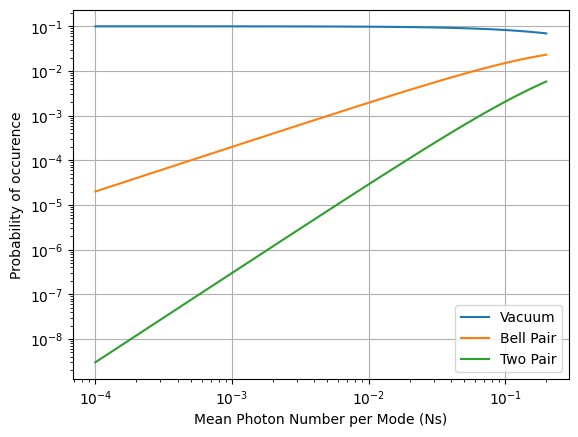

In [2]:
def distribution_function(Ns,n):
    return (n+1)*(Ns**n)/((Ns+1)**(n+2))

def normalization(Ns):
    return math.sqrt(np.sum(distribution_function(Ns,0) + distribution_function(Ns,1) + distribution_function(Ns,2)))

range_Ns = np.logspace(-4,math.log10(0.2),100)
norm = normalization(range_Ns)
vacuum_comp = distribution_function(range_Ns,0)/norm
bell_pair = distribution_function(range_Ns,1)/norm
two_pair = distribution_function(range_Ns,2)/norm

plt.plot(range_Ns,vacuum_comp,label="Vacuum")
plt.plot(range_Ns,bell_pair,label="Bell Pair")
plt.plot(range_Ns,two_pair,label="Two Pair")
plt.legend()

plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.xlabel("Mean Photon Number per Mode (Ns)")
plt.ylabel("Probability of occurence")

plt.show()

As highlighted, above, as we increase $N_s$, the proportion of the vacuum terms decreases, while the proportion of the two-pair terms increases. This is a key limitation of SPDC based entanglement generation sources. We can alternatively visualize this by plotting the proportion of the Bell pair and noise term to the vacuum term as a function of $N_s$.

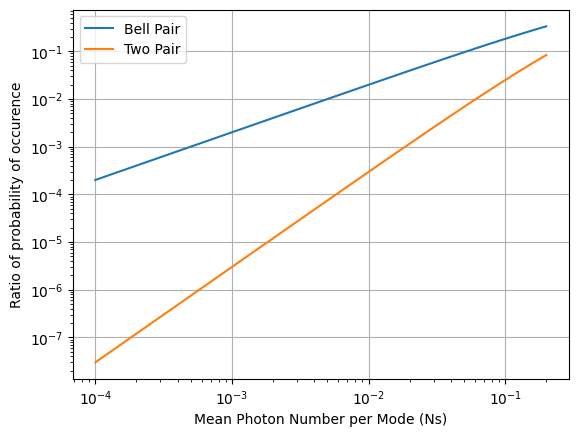

In [3]:
range_Ns = np.logspace(-4,math.log10(0.2),100)
norm = normalization(range_Ns)
vacuum_comp = distribution_function(range_Ns,0)/norm
bell_pair = distribution_function(range_Ns,1)/norm
two_pair = distribution_function(range_Ns,2)/norm

prop_bell_pair = bell_pair/vacuum_comp
prop_two_pair = two_pair/vacuum_comp

plt.plot(range_Ns,prop_bell_pair,label="Bell Pair")
plt.plot(range_Ns,prop_two_pair,label="Two Pair")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.xlabel("Mean Photon Number per Mode (Ns)")
plt.ylabel("Ratio of probability of occurence")

plt.show()

## Building a Heralded Entanglement Generation Source

### Motivation and Main Theoretical Idea

The key limitation of SPDC based entanglement generation sources is that they are inherently probabilistic and the presence of noise terms like $\ket{2,0,0,2} \ket{0,2,2,0} \ket{1,1,1,1}$. We shall now look at a few strategies on how to build a source that seeks to alleviate some of the issues with SPDC based entanglement generation sources.

The first idea would be to use single photons heralded by a detector. This is a very common strategy in quantum optics and is used in a variety of applications. The idea is to use a single photon detector to herald the presence of a single photon. This is done by placing the detector in one of the modes of the SPDC source. The detector is then used to herald the presence of a single photon in the other mode. A multitude of single photons generated in such a manner can then be used to generate entanglement by using a linear photonic circuit. 
The second idea would be to use the existing SPDC based source and perform post-selection on the generated photons. Specifically, we need an auxilliary system that can herald the presence of the required Bell pair terms (i.e. $\ket{1,0,0,1} + \ket{0,1,1,0}$). The system must also be capable of reproducing the photonic states in the required Bell pair terms with a high probability. This is a non-trivial task that could be achieved by certain types of quantum memories or a some complicated measurement scheme. We shall not delve into the details of this scheme here except noting that this is quite complicated to achieve in practice. 

The final idea would be to use a pair of existing SPDC  based sources and perform post-selection on the output photons by performing a joint measurement. As you may already be familiar, the Bell state projection measurement is a joint measurement on two qubits that projects them onto one of the four Bell states. This can be achieved with the linear optical circuits comprising of beamsplitters and detectors. A 'succesful' Bell state measurement, (ideally) projects the umeasured photons in the state $\ket{\Psi^+}$. Furthermore, since the measurement is heralded, we *know* when entanglement is generated. This is the basis of the 'cascaded heralded source' proposed in the [**following paper**](https://doi.org/10.1103/PhysRevApplied.17.034071.).

![SPDC](./Images/MPS_Cascaded_Source.png)
**Fig.**: Diagram of the  cascaded source construction. (Image adapted from <a href="https://doi.org/10.1103/PhysRevApplied.17.034071">Dhara et. al 2022</a>)
 
The cascaded source shown in the figure above comprises of a pair of SPDC sources, each of which generates a pair of photons. The photons are then sent through a linear optical circuit that performs a Bell state measurement. The measurement is heralded by the detection of a pair of photons in a few specific modes. If the measurement is successful, then the photons are expected to be projected into the state $\ket{\Psi^+}$ - certainly this is so if the the SPDC sources generated Bell-pairs natively. If the measurement is not successful, then the photons are discarded. However, given the probabilistic nature of the SPDC sources, the output state must be computed from the entire state being conditioned  on the measurement being successful. We shall not delve into the details of this computation here, and refer the reader to the original paper for the details. However, we can write the form of the quantum state that is generated by the cascaded source as

\begin{equation}
\ket{S}=\frac{1}{\sqrt{2}}\left[\frac{\ket{1,0,0,1}+ (-1)^{m_1} \ket{0,1,1,0}}{\sqrt{2}} + (-1)^{m_2} \frac{\ket{0,0,1,1}+ (-1)^{m_1} \ket{1,1,0,0}}{\sqrt{2}} \right]
\end{equation}
where $m_1,m_2$ are dependent on the click patterns in the Bell state measurement. Paying close attention to the state, we have the necessary Bell pair terms that we need for the protocol and gotten rid of the vacuum and two-pair terms. However, we have introduced a new term $\ket{0,0,1,1}+ (-1)^{m_1} \ket{1,1,0,0}$ that is not in the polarization basis. However of a quantum communication protocol, this term is something that can be dealt with in the following fashion.

Consider that A and B receive the $\ket{0,0,1,1}+ (-1)^{m_1} \ket{1,1,0,0}$ term. If they measure their photons, they notice that  either (1) Alice signals the presence of a photon and Bob does not i.e. $\ket{1,1,0,0}$, or (2) Bob signals the presence of a photon and Alice does not. In either case, they know that the other party has not received a photon. Thus they can simply discard the state and try again. This is a key feature of the 'undesired term' that gives the cascaded source its edge. Note that all of the above is true when we assume that Alice and Bob do not receive stray 'noise' photons from elsewhere.

### Tutorial: Evaluating the Quality of a Cascaded Entanglement Generation Source
Below we shall look at how to evaluate the quality of a cascaded entanglement generation source. We want to incorporate the following non-idealities in the source:
- Loss in the SPDC sources being coupled to the detector
- Loss in the undetected output modes of the SPDC sources
- Detector dark clicks

Rather than deriving what the state of the cascaded source looks like after inclusion of all these non-linearities we use the `casc_src_density_matrix` function that will return the density matrix of the state. The function returns th entire 36 x 36 density matrix of the state. For the fidleity with the state $\ket{\Psi^+}$, we need to consider the 4 x 4 submatrix corresponding to the Bell pair terms. The relevant submatrix corresponds to the position {[10,10],[10,20],[20,10],[20,20]} in the density matrix. 

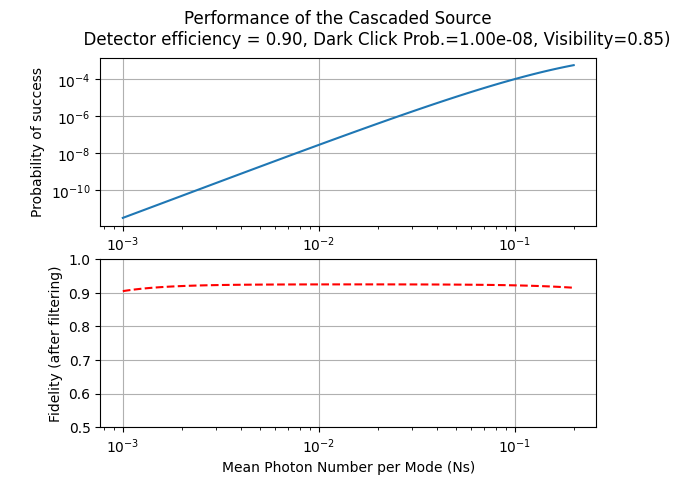

In [4]:
## Initialize the system
fid_array = []
prob_success_array = []
range_Ns = np.logspace(-3,math.log10(0.2),100)

# Ordering of parameters: Ns, eta_Alice,eta_Bob,eta_detectors,prob_dark_click,visibility
# Modify the parameters below to see how the performance changes
eta_A=eta_B=1
eta_detectors=0.9
prob_dark_click=1e-8;
visibility=0.85

for Ns in range_Ns:
    matrix=cascaded_source_density_matrix(Ns,eta_A,eta_B,eta_detectors,prob_dark_click,visibility)
    norm = np.trace(matrix)
    prob_success_array.append(norm*4)
    fid_array.append((matrix[9,9]+matrix[19,19]+matrix[19,9]+matrix[9,19])/(norm))

fig, axs = plt.subplots(2)
fig.suptitle('Performance of the Cascaded Source \n \
             Detector efficiency = {:2.2f}, Dark Click Prob.={:4.2e}, Visibility={:2.2f})'\
             .format(eta_detectors,prob_dark_click,visibility))
axs[0].plot(range_Ns, prob_success_array)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].grid()
axs[0].set_xlabel("Mean Photon Number per Mode (Ns)")
axs[0].set_ylabel("Probability of success")
#axs[0].set_ylim([1e-12,1e-3])   

###
axs[1].plot(range_Ns, fid_array,'r--')
axs[1].set_xscale("log")
axs[1].grid()
axs[1].set_xlabel("Mean Photon Number per Mode (Ns)")
axs[1].set_ylabel("Fidelity (after filtering)")
axs[1].set_ylim([0.5,1.0])  

plt.show()

### Multiplexing Sources
We have hence shown that the cascaded source operates in a 'heralded' fashion to generate photonic states that are 'better' than the SPDC source. However, the price ot pay is that the overall probablity of generating a photon pair is worse. We not only need to consider that two terms in the SPDC source are both $\ket{\Psi^\pm}$ which is propostional to $p(1)^2$ but also that the Bell state measurement is successful, which is an additional factor of $1/2$. Since for $N_s<0.2$, $p(1)\ll 1$ it is no surpirse that the cascaded source is not very bright. However since the source is heralded, we can multiplex multiple sources together to generate entanglement at a higher rate. This is the basis of the 'multiplexed heralded source' proposed in extension to the original source design.

![Muxed_Cascaded_Source](./Images/MPS_Muxed_Cascaded_Source.png)
**Fig.**:Diagram of the multiplexed casacded source construction (the physical multiplexing shown here is simply a depiction; Image adapted from  <a href="https://doi.org/10.1103/PhysRevApplied.17.034071">Dhara et. al 2022</a>)

As shown in the figure above, we consider $M$ such sources multiplexed together so that atleast one of them succeeds. Each source is conneected to a local controller that switches the successfully generated photon pairs out. If the the probability of generating a single pair is $p_{\mathrm{single}}$, then the multiplexed source succeeds with probability $$p_{\mathrm{multi}} (M) = 1-(1-p_{\mathrm{single}})^M \approx 1- (1- M\times p_{\mathrm{single}})= M\times p_{\mathrm{single}},$$
the latter simplification being true when $ p_{\mathrm{single}}\ll 1$. Thus we can choose $M$ to be large enough to ensure that the multiplexed source is 'near deterministic', i.e., $p_{\mathrm{multi}} (M) \approx 1$.

A big challenge is that even with the best hardware and near perfect operation, $M$ turns out to be around $10000$! This is not practical for any real world implementation using spatially separate sources. One alternative is to consider a source that is integrated on a chip, where the multiplexing can be done on the chip itself. Alternatively, we can consider the use of frequency multiplexing to multiplex the sources together. This is the basis of the 'frequency multiplexed heralded source' also popularly called the 'zero added loss multiplexing' (ZALM) source proposed in [Chen et. al 2023](http://dx.doi.org/10.1103/PhysRevApplied.19.054029). We ignore the details of how frequency multiplexing is achieved in the ZALM source here, but the interested reader can refer to the original paper for more details. For all practical purposes, we can consider the ZALM source to generate the state $\ket{S}$ with high probability with additional information about the frequency of the output photons.



### Tutorial: Evaluating the Quality of a Multiplexed Cascaded Entanglement Generation Source
Below we shall look at how to evaluate the quality of a multiplexed cascaded entanglement generation source. We want to incorporate the same non-idealities in the source as before. We will once again use the `casc_src_density_matrix` function. We will use the formula specified above to compute the probability of success of the multiplexed source. We can implement the various kinds of multiplexing by simply changing the output loss scaling factor.

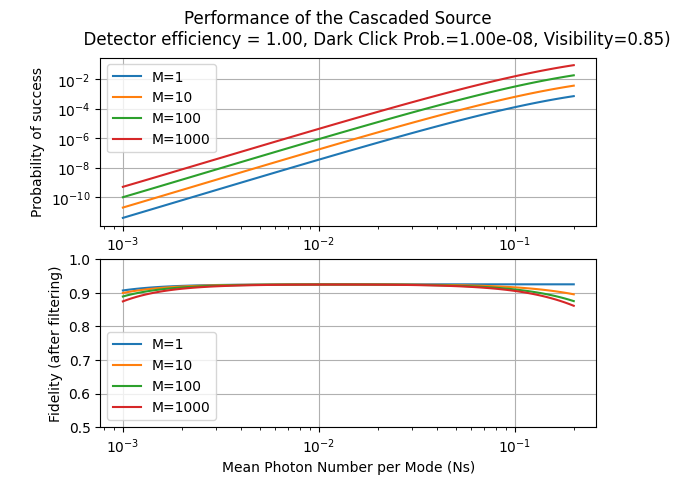

In [5]:
## Initialize the system
range_Ns = np.logspace(-3,math.log10(0.2),100)
range_M = [1,10,100,1000]  
fid_array = np.zeros((len(range_Ns),len(range_M)))
prob_success_array = np.zeros((len(range_Ns),len(range_M)))

# Ordering of parameters: Ns, eta_Alice,eta_Bob,eta_detectors,prob_dark_click,visibility
# Modify the parameters below to see how the performance changes
eta_A=eta_B=1
eta_detectors=1
prob_dark_click=1e-8;
visibility=0.85

mult_loss=0.9;

for i1 in range(len(range_Ns)):
    for i2 in range(len(range_M)):
        det_loss = eta_detectors*mult_loss**math.log2(range_M[i2])
        matrix=cascaded_source_density_matrix(range_Ns[i1],eta_A,eta_B,det_loss,prob_dark_click,visibility)
        norm = np.trace(matrix)
        prob_success_array[i1,i2]=1-(1-(norm*4))**range_M[i2]
        fid_array[i1,i2]=(matrix[9,9]+matrix[19,19]+matrix[19,9]+matrix[9,19])/norm


# Plotting the results
fig, axs = plt.subplots(2)
fig.suptitle('Performance of the Cascaded Source \n \
             Detector efficiency = {:2.2f}, Dark Click Prob.={:4.2e}, Visibility={:2.2f})'\
             .format(eta_detectors,prob_dark_click,visibility))

# Plotting the probability of success
for i2 in range(len(range_M)):
    axs[0].plot(range_Ns, prob_success_array[:,i2],label="M={}".format(range_M[i2]))
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].grid()
axs[0].legend()
axs[0].set_xlabel("Mean Photon Number per Mode (Ns)")
axs[0].set_ylabel("Probability of success")
#axs[0].set_ylim([1e-12,1e-3])   

# Plotting the fidelity
for i2 in range(len(range_M)):
    axs[1].plot(range_Ns, fid_array[:,i2],label="M={}".format(range_M[i2]))
axs[1].set_xscale("log")
axs[1].grid()
axs[1].legend()
axs[1].set_xlabel("Mean Photon Number per Mode (Ns)")
axs[1].set_ylabel("Fidelity (after filtering)")
axs[1].set_ylim([0.5,1.0])  

plt.show()

## Quantum Memories: Sneak Peek
As highlighted above, in the context of the protocol, we require quantum memories that not only can can store quantum information for a long time but are also also be able to interact with photons. The latter requirement is necessary for the memories to be able to store entangled photons coming from the midpoint source at C. Furthermore, we require that the end parties A and B **know** when their share of the entangled photon pair is successfully stored in their memories.

One implementation of this is to use a Duan-Kimble scheme for loading polarization encode photons into a quantum memory. The scheme is shown in the figure below.

![DK_Scheme](./Images/MPS_DK_Scheme.png)
**Fig.**: Duan Kimble scheme for the teleportation of the state of a single photonic qubit into a quantum memory. (Image adapted from  <a href="https://doi.org/10.1038/s41534-020-00337-3">Chen et. al 2021</a>)

The Duan-Kimble scheme relies on being able to perform a controlled phase-rotation of a polarization qubit based on the state of a quantum memory. Incoming photons separated based on their polarization using a polarizing beam splitter. One of the polarization (let us say $V$) is simply reflected of a mirror. The $H$ polarized photon is made to interact with a cavity that is coupled to a quantum memory. The cavity is designed such that the $H$ polarized photon experiences a phase shift of $\pi$ when it interacts with the cavity if and only if the memory is in the $\ket{1}_M$ state. Otherwise it is simply reflected out of the cavity. The two photons are then recombined using the same polarizing beam splitter. As per the conditional interaction specified above, the memory implements the state transformation
\begin{equation}
\frac{\ket{0}_M +\ket{1}_M}{\sqrt{2}} \otimes (\alpha \ket{H} +\beta \ket{V}) \rightarrow \ket{0}_M \otimes (\alpha \ket{H} + \beta \ket{V}) + \ket{1}_M \otimes (-\alpha \ket{H} + \beta \ket{V})
\end{equation}
This can be used to perform a CPHASE gate based single qubit teleportation as shown below. The detection of the photon in the $\ket{A}$ or $\ket{D}$ modes heralds the successful teleportation of the state $\alpha \ket{H} + \beta{V}$ to the memory upto some phase rotation. 

Another way to load the photonic qubit on the memory, is to have a memory emit a photonic qubit and interact the incoming qubit (from C) with the generated qubit on a photonic Bell state measurement circuit. This is done by initializing the memory in the $(\ket{0}_M+\ket{1}_M)/\sqrt{2}$ state and applying conditional pulses as shown below to generate the state $(\ket{0}_M \ket{0,1} + \ket{1}_M \ket{1,0})/\sqrt{2}$ which is the Bell state $\ket{\Psi^+}$ between the memory and the photon.

![MPS_Emission_Scheme](./Images/MPS_Emission_Scheme.png)
**Fig.**: Emission of a photonic qubit from a quantum memory.



## Building and Simulating a Midpoint Source Protocol from the Components

Now that we have looked the various components of the protocol, we can start envisioning how to build and simulate it. Specifically we have already seen the following in action
- The SPDC source and the state it generates
- The improved cascaded source, and its multiplexed counter-part and the states they generate
- The quantum memories and their interaction with the incoming photon

The entire detailed layout of the protocol is given in the figure below. Rather than derive the states from first principles we shall use the functions `cascaded_source_density_matrix` and `cascaded_source_swapped_state` to evaluate our protocols. These functions return the density matrix of the state generated by the cascaded source and the state of the quantum memories after the state jas been loaded on the memories respectively. The functions take the following parameters:
- `cascaded_source_density matrix`
  - `Ns`: Mean photon number per mode in the SPDC sources (usually between 1e-4 and 0.2)
  - `eAs`,`eBs`: Efficiency of the source coupled out to Alice's and Bob's transmission side respectively
  - `eD`: Internal efficiency of the detectors in the cascaded source
  - `Pd`: Dark count probability of the detectors in the cascaded source (per mode; usually between 0 and 1e-1)
  - `VisF`: Visibility of the Bell state measurement in the cascaded source (usually between 0 and 1)
- `cascaded_source_swapped_state`
  - `Ns`: Mean photon number per mode in the SPDC sources (usually between 1e-4 and 0.2)
  - `eAm`,`eBm`: Efficiency of Alice's and Bob's memory coupled to the swaps respectively (we will keep this to be one for the time being)
  - `eAs`,`eBs`: Efficiency of the source coupled out to Alice's and Bob's swaps respectively
  - `eD`: Internal efficiency of the detectors in the cascaded source
  - `Pd_Charlie`: Dark count probability of the detectors in the cascaded source (per mode; usually between 0 and 1e-1)
  - `Pd_Alice`,`Pd_Bob`: Dark count probability of the detectors in Alice's and Bob's swaps respectively (per mode; usually between 0 and 1e-1)
  - `VisF`: Visibility of the Bell state measurements lumped together (usually between 0 and 1)

### Tutorial: Evaluating the Quality of the Midpoint Source Protocol
Below we shall look at how to evaluate the quality of the midpoint source protocol. We want to incorporate the same non-idealities in the source as before. We will use the formula specified above to compute the probability of success of the multiplexed source. We can implement the various kinds of multiplexing by simply changing the output loss scaling factor for the source.

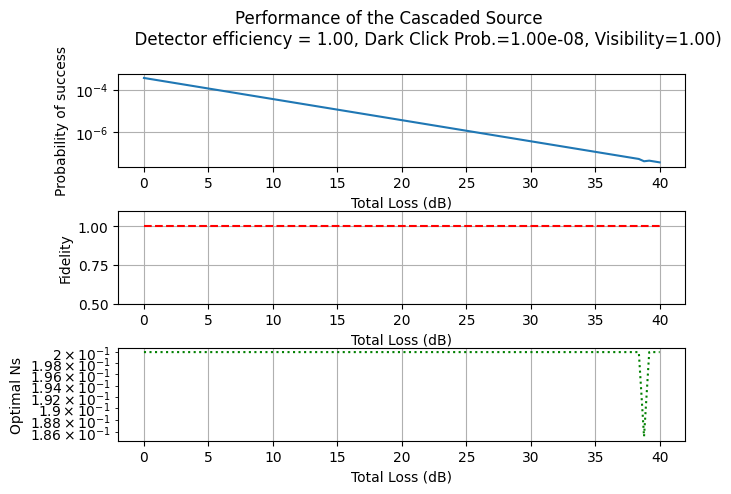

In [6]:
## Initialize the parameters of the system
range_Ns = np.logspace(-4,math.log10(0.2),100)
mux_size = 1
loss_range = np.linspace(0,20,100)
eta_range = 10**(-loss_range/10)
eta_detectors=1
prob_dark_click=1e-8;
visibility=1
memory_loss=1

# Initialize the arrays to store the results
source_prob_success_array = np.zeros((len(range_Ns),len(eta_range)))
swapped_state_fidelity_array = np.zeros((len(range_Ns),len(eta_range)))
swapped_state_prob_success_array = np.zeros((len(range_Ns),len(eta_range)))
opti_swap_prob_success_array = np.zeros((len(eta_range),1))
opti_swap_fidelity_array = np.zeros((len(eta_range),1))
opti_Ns = np.zeros((len(eta_range),1))


# Loop over the parameters
for i2 in range(len(eta_range)):
    for i1 in range(len(range_Ns)):
        # Calculate the density matrix of the source
        matrix=cascaded_source_density_matrix(range_Ns[i1],eta_range[i2],eta_range[i2],eta_detectors,prob_dark_click,visibility)
        norm_source = np.trace(matrix) # Multiply by 4 to account for the 4 possible outcomes of the swaps
        source_prob_success_array[i1,i2]=1-(1-(norm_source*4))**mux_size

        # Calculate the density matrix of the swapped state
        # (Ns, eAm, eBm, eAs, eBs, eD, Pd_Charlie, Pd_Alice, Pd_Bob, VisF=1, gA=0.5, gB=0.5):
        matrix=cascaded_source_swapped_state(range_Ns[i1],memory_loss,memory_loss,eta_range[i2],eta_range[i2],eta_detectors,prob_dark_click,prob_dark_click,prob_dark_click,visibility)
        norm_swap = np.trace(matrix) 
        swapped_state_prob_success_array[i1,i2]=64*source_prob_success_array[i1,i2]*norm_swap/norm_source # Multiply by 64 to account for the 4^3 possible outcomes of the 3 swaps
        swapped_state_fidelity_array[i1,i2]=(matrix[1,1]+matrix[2,2]+matrix[1,2]+matrix[2,1])/(2*norm_swap)
    # Evaluate best possible swap fidelity and success probability
    arg_max=np.argmax(swapped_state_prob_success_array[:,i2]**2+swapped_state_fidelity_array[:,i2]**2)
    opti_swap_prob_success_array[i2]=swapped_state_prob_success_array[arg_max,i2]
    opti_swap_fidelity_array[i2]=swapped_state_fidelity_array[arg_max,i2]
    opti_Ns[i2]=range_Ns[arg_max]

# Plotting the results
fig, axs = plt.subplots(3)
fig.suptitle('Performance of the Cascaded Source \n \
             Detector efficiency = {:2.2f}, Dark Click Prob.={:4.2e}, Visibility={:2.2f})'\
             .format(eta_detectors,prob_dark_click,visibility))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axs[0].plot(2*loss_range, opti_swap_prob_success_array)
axs[0].set_xscale("linear")
axs[0].set_yscale("log")
axs[0].grid()
axs[0].set_xlabel("Total Loss (dB)")
axs[0].set_ylabel("Probability of success")

axs[1].plot(2*loss_range, opti_swap_fidelity_array,'r--')
axs[1].set_xscale("linear")
axs[1].grid()
axs[1].set_xlabel("Total Loss (dB)")
axs[1].set_ylabel("Fidelity")
axs[1].set_ylim([0.5,1.1])

axs[2].plot(2*loss_range, opti_Ns,'g:')
axs[2].set_xscale("linear")
axs[2].set_yscale("log")
axs[2].grid()
axs[2].set_xlabel("Total Loss (dB)")
axs[2].set_ylabel("Optimal Ns")

plt.show()
